## Aprenentatge no supervisat
## S15 T01: Classifica els diferents vols
### Nivell 1
### Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-mean

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist
from sklearn.compose import ColumnTransformer



In [2]:
df=pd.read_csv('DelayedFlights.csv')
df.keys()

Index(['Unnamed: 0', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum',
       'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

In [3]:
df.head()


,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,...,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,...,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,...,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,...,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,...,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


first steps
- Clean dataset
- impute missing values
- split the data between categorical and numerical
- preprocess the data

In [4]:
df.drop(['Unnamed: 0','Year','TailNum','CancellationCode','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','TaxiIn','TaxiOut','ActualElapsedTime','CRSElapsedTime','DepTime','CRSDepTime','DepDelay'],axis=1,inplace=True)

In [5]:
df.keys()

Index(['Month', 'DayofMonth', 'DayOfWeek', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'FlightNum', 'AirTime', 'ArrDelay', 'Origin', 'Dest',
       'Distance', 'Cancelled', 'Diverted'],
      dtype='object')

I create a new feature called Status that  will be 1 if the flight arrive earlier 2 if is on time  and 3 if is arrive late and  4 if is cancelled or diverted 

In [6]:
df.loc[df.ArrTime<df.CRSArrTime,'Status']=1
df.loc[df.ArrTime==df.CRSArrTime,'Status']=2
df.loc[df.ArrTime>df.CRSArrTime,'Status']=3
df.loc[(df.Cancelled==1) | (df.Diverted==1),'Status']=4


In [7]:
df.isnull().sum()

Month               0
DayofMonth          0
DayOfWeek           0
ArrTime          7110
CRSArrTime          0
UniqueCarrier       0
FlightNum           0
AirTime          8387
ArrDelay         8387
Origin              0
Dest                0
Distance            0
Cancelled           0
Diverted            0
Status              0
dtype: int64

In [8]:
for feature in df[['AirTime','ArrDelay','ArrTime']]:
    df.loc[((df.Cancelled==1) | (df.Diverted==1)) & df[feature].isnull() ,feature]=0

Drop unnecesary columns

In [9]:
df.drop(['AirTime', 'ArrDelay','Cancelled', 'Diverted','ArrTime', 'CRSArrTime'],axis=1,inplace=True)

In [10]:
## I will take a random sample, impute missing values and then split the data by numerical and categorial 
smpl = df.shape[0]*0.20
df_sample = df.sample(int(smpl))

In [11]:
df_sample.isnull().sum()

Month            0
DayofMonth       0
DayOfWeek        0
UniqueCarrier    0
FlightNum        0
Origin           0
Dest             0
Distance         0
Status           0
dtype: int64

In [12]:
df_sample.keys()

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'FlightNum',
       'Origin', 'Dest', 'Distance', 'Status'],
      dtype='object')

In [13]:
numeric_data = pd.DataFrame(df_sample[['Distance','FlightNum']])
categorical_data = df_sample.drop(['Distance','FlightNum'],axis=1)

numeric_data

,Distance,FlightNum
619441,491,6023
230711,717,7132
432434,430,5433
1879311,335,4902
785629,794,5884
...,...,...
446170,988,4029
1379585,627,394
1111821,283,149
528371,2288,75


In [14]:
encoding =categorical_data[['Origin','Dest']]
le_Origin_Dest= LabelEncoder()
le_Origin_Dest.fit(encoding.stack().unique())
numeric_data['OriginEnc'] = le_Origin_Dest.transform(encoding['Origin'])
numeric_data['DestEnc'] = le_Origin_Dest.transform(encoding['Dest'])


In [15]:
categorical_data.drop(['Origin','Dest'],axis=1,inplace=True)

In [16]:
## Encoding  the remain categorical features
le_carrier= LabelEncoder()
categorical_data['UniqueCarrier']= le_carrier.fit_transform(categorical_data['UniqueCarrier'])


In [17]:
## transform time variables into cosinus series
categorical_data['Month'] = np.cos(2 * np.pi * df_sample['Month']/df_sample['Month'].max())
categorical_data['DayofMonth'] = np.cos(2 * np.pi * df_sample['DayofMonth']/df_sample['DayofMonth'].max())
categorical_data['DayOfWeek'] = np.cos(2 * np.pi * df_sample['DayOfWeek']/df_sample['DayOfWeek'].max())

In [18]:
df_sample_processed = pd.concat([numeric_data,categorical_data],axis=1)

In [19]:
df_sample_processed.describe()

,Distance,FlightNum,OriginEnc,DestEnc,Month,DayofMonth,DayOfWeek,UniqueCarrier,Status
count,387351.000000,387351.000000,387351.000000,387351.000000,3.873510e+05,387351.000000,387351.000000,387351.000000,387351.000000
mean,764.504411,2186.651360,145.244824,148.965752,-2.702920e-02,-0.023719,-0.011468,11.119754,2.729073
std,573.419905,1946.412581,79.593718,80.516537,7.274674e-01,0.699169,0.704939,5.931707,0.684086
min,11.000000,1.000000,0.000000,0.000000,-1.000000e+00,-0.994869,-0.900969,0.000000,1.000000
25%,338.000000,610.000000,79.000000,79.000000,-8.660254e-01,-0.758758,-0.900969,6.000000,3.000000
50%,606.000000,1544.000000,154.000000,156.000000,6.123234e-17,-0.050649,-0.222521,13.000000,3.000000
75%,997.000000,3430.000000,209.000000,214.000000,8.660254e-01,0.688967,0.623490,17.000000,3.000000
max,4962.000000,9740.000000,299.000000,299.000000,1.000000e+00,1.000000,1.000000,19.000000,4.000000


After preprocess the data we need to  standarize before the implementation of Kmeans

In [20]:
numeric_data

,Distance,FlightNum,OriginEnc,DestEnc
619441,491,6023,180,209
230711,717,7132,209,210
432434,430,5433,47,72
1879311,335,4902,222,161
785629,794,5884,79,248
...,...,...,...,...
446170,988,4029,80,265
1379585,627,394,198,63
1111821,283,149,195,162
528371,2288,75,134,156


In [21]:

df_scaled = df_sample_processed.copy()
df_scaled.keys()


Index(['Distance', 'FlightNum', 'OriginEnc', 'DestEnc', 'Month', 'DayofMonth',
       'DayOfWeek', 'UniqueCarrier', 'Status'],
      dtype='object')

In [22]:

features = df_scaled[['Distance','FlightNum']]
scaler = MinMaxScaler().fit(features.values)
df_scaled[features.columns] = scaler.transform(features.values)


In [23]:
df_scaled.describe()

,Distance,FlightNum,OriginEnc,DestEnc,Month,DayofMonth,DayOfWeek,UniqueCarrier,Status
count,387351.000000,387351.000000,387351.000000,387351.000000,3.873510e+05,387351.000000,387351.000000,387351.000000,387351.000000
mean,0.152192,0.224423,145.244824,148.965752,-2.702920e-02,-0.023719,-0.011468,11.119754,2.729073
std,0.115819,0.199858,79.593718,80.516537,7.274674e-01,0.699169,0.704939,5.931707,0.684086
min,0.000000,0.000000,0.000000,0.000000,-1.000000e+00,-0.994869,-0.900969,0.000000,1.000000
25%,0.066047,0.062532,79.000000,79.000000,-8.660254e-01,-0.758758,-0.900969,6.000000,3.000000
50%,0.120178,0.158435,154.000000,156.000000,6.123234e-17,-0.050649,-0.222521,13.000000,3.000000
75%,0.199152,0.352090,209.000000,214.000000,8.660254e-01,0.688967,0.623490,17.000000,3.000000
max,1.000000,1.000000,299.000000,299.000000,1.000000e+00,1.000000,1.000000,19.000000,4.000000


In [24]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df_scaled)
    kmeanModel.fit(df_scaled)
 
    distortions.append(sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / df_scaled.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(df_scaled, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / df_scaled.shape[0]
    mapping2[k] = kmeanModel.inertia_

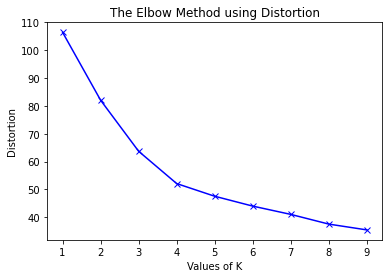

In [25]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

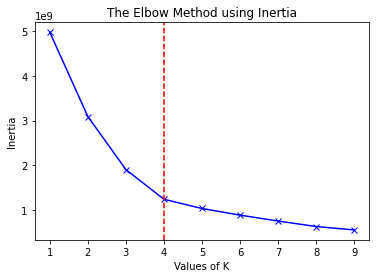

In [26]:
plt.plot(K, inertias, 'bx-')
plt.axvline(4, color='r', ls='--')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

to be sure  that the optimal k is 4. I will implement the 'Elbow method

In [27]:
 #I will use kneelocator to determinate the number of clusters
kl = KneeLocator(range(1, 10), inertias, curve="convex", direction="decreasing")
kl.elbow

4

base on the results of kneeLocator and Elbow method I will choose 3 clusters

In [28]:
kmeans = KMeans(n_clusters = 4)

In [29]:
kmeans.fit(df_scaled)

KMeans(n_clusters=4)

In [30]:
df_scaled['Clusters'] = kmeans.fit_predict(df_scaled)

In [31]:
#df_scaled['OriginEnc'] = le_Origin_Dest.inverse_transform(df_scaled['OriginEnc'])
#df_scaled['DestEnc'] = le_Origin_Dest.inverse_transform(df_scaled['DestEnc'])


In [32]:
#df_scaled['DestEnc'] = le_Origin_Dest.inverse_transform(df_scaled['DestEnc'])

In [33]:
#df_scaled['UniqueCarrier']=le_carrier.inverse_transform(df_scaled['UniqueCarrier'])

In [34]:
#df_scaled['Distance'] = scaler.inverse_transform(df_scaled[['Distance','FlightNum']])

In [35]:
df_scaled

,Distance,FlightNum,OriginEnc,DestEnc,Month,DayofMonth,DayOfWeek,UniqueCarrier,Status,Clusters
619441,0.096950,0.618339,180,209,-5.000000e-01,0.688967,-0.222521,14,3.0,0
230711,0.142597,0.732211,209,210,5.000000e-01,-0.050649,-0.222521,19,3.0,0
432434,0.084629,0.557757,47,72,6.123234e-17,-0.954139,0.623490,13,3.0,3
1879311,0.065441,0.503234,222,161,1.000000e+00,-0.050649,-0.222521,11,3.0,0
785629,0.158150,0.604066,79,248,-8.660254e-01,0.979530,-0.222521,14,3.0,1
...,...,...,...,...,...,...,...,...,...,...
446170,0.197334,0.413595,80,265,6.123234e-17,0.918958,0.623490,14,3.0,1
1379585,0.124419,0.040353,198,63,-5.000000e-01,-0.050649,-0.222521,12,3.0,2
1111821,0.054938,0.015197,195,162,-8.660254e-01,-0.994869,-0.222521,18,3.0,0
528371,0.459907,0.007598,134,156,6.123234e-17,0.347305,-0.222521,1,3.0,1


I'm going to explore the data to see  patterns that explain  the cluster distribution

<AxesSubplot:xlabel='OriginEnc', ylabel='DestEnc'>

C:\Users\adria\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


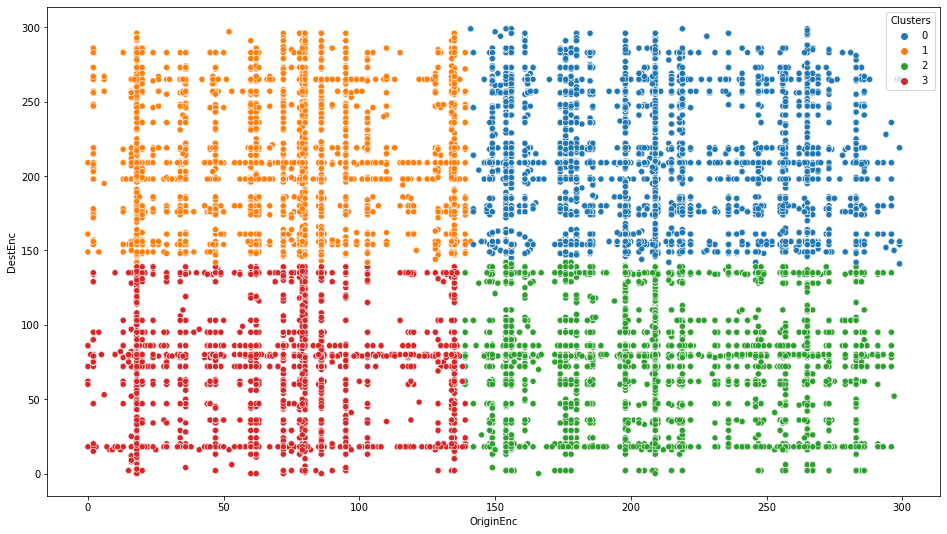

In [43]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=df_scaled, x='OriginEnc', y='DestEnc', hue="Clusters",palette=["C0", "C1", "C2","C3"])


we can see that kmeans separate 4 diferents clusters throught Origin and Dest variables 

***Using PCA***

In [37]:
df_scaledPCA = df_scaled.drop('Clusters',axis=1)


In [38]:
df_scaledPCA

,Distance,FlightNum,OriginEnc,DestEnc,Month,DayofMonth,DayOfWeek,UniqueCarrier,Status
619441,0.096950,0.618339,180,209,-5.000000e-01,0.688967,-0.222521,14,3.0
230711,0.142597,0.732211,209,210,5.000000e-01,-0.050649,-0.222521,19,3.0
432434,0.084629,0.557757,47,72,6.123234e-17,-0.954139,0.623490,13,3.0
1879311,0.065441,0.503234,222,161,1.000000e+00,-0.050649,-0.222521,11,3.0
785629,0.158150,0.604066,79,248,-8.660254e-01,0.979530,-0.222521,14,3.0
...,...,...,...,...,...,...,...,...,...
446170,0.197334,0.413595,80,265,6.123234e-17,0.918958,0.623490,14,3.0
1379585,0.124419,0.040353,198,63,-5.000000e-01,-0.050649,-0.222521,12,3.0
1111821,0.054938,0.015197,195,162,-8.660254e-01,-0.994869,-0.222521,18,3.0
528371,0.459907,0.007598,134,156,6.123234e-17,0.347305,-0.222521,1,3.0


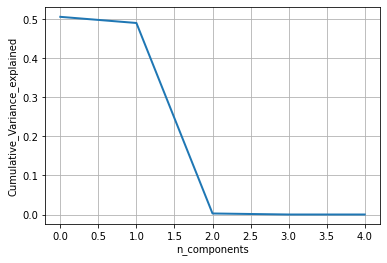

In [64]:
pca=PCA()  
pca.n_components=5 
pca_data=pca.fit_transform(df_scaledPCA)
percentage_var_explained = pca.explained_variance_ratio_;  
cum_var_explained=np.cumsum(percentage_var_explained)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(percentage_var_explained,linewidth=2)  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

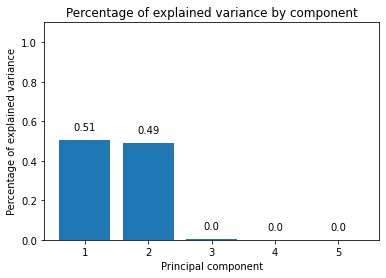

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_scaled.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentage of explained variance by component')
ax.set_xlabel('Principal components')
ax.set_ylabel('Percentage of explained variance');

In [66]:
pca_data = pd.DataFrame(pca_data)


In [67]:
pca_data=pca_data.loc[:,:2]

In [68]:
pca_data.rename(columns={0: 'principal component 1', 1: 'principal component 2',2:'principal component 3'}, inplace=True)

In [70]:
pca_data

,principal component 1,principal component 2,principal component 3
0,-68.642645,10.177466,-2.219971
1,-80.311024,36.791271,-6.969935
2,107.751836,-62.918552,-3.183742
3,-39.490215,66.903048,0.837233
4,-67.645419,-98.084426,-2.828379
...,...,...,...
387346,-83.815424,-103.425050,-2.712951
387347,60.440286,80.746717,-0.966856
387348,-30.524385,41.476932,-6.380743
387349,-2.301828,-13.102366,10.069842


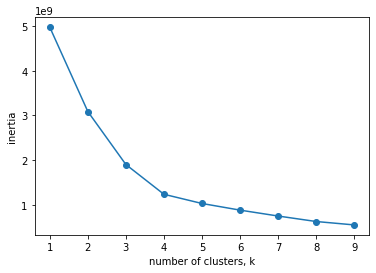

In [71]:
ks = range(1, 10)
inertias = []
for k in ks:
    
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_data)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


we observe that same as without PCA the optimal K is 4

In [72]:
kmeans = KMeans(n_clusters = 4)

In [73]:
kmeans.fit(pca_data)

KMeans(n_clusters=4)

In [74]:
pca_data['Clusters'] = kmeans.fit_predict(pca_data)

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

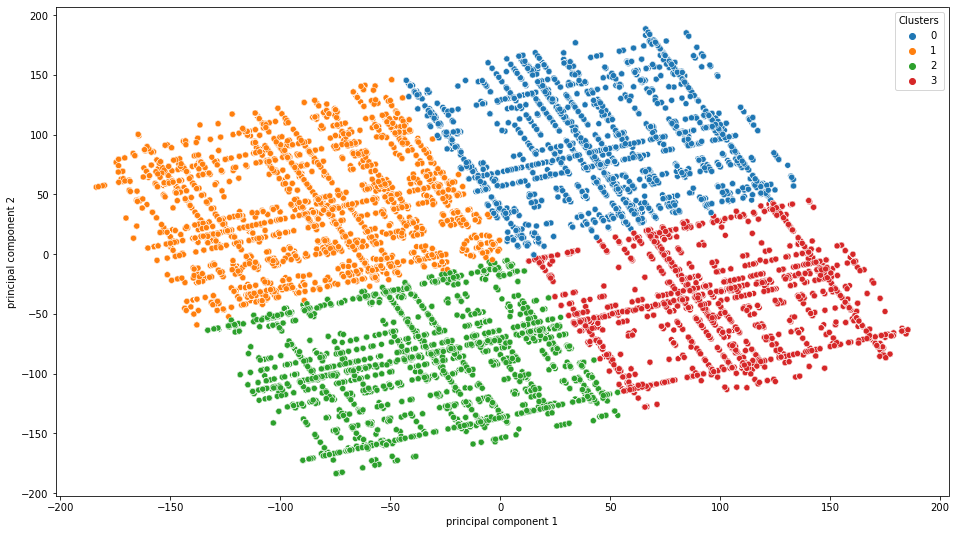

In [75]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=pca_data, x="principal component 1", y="principal component 2", hue="Clusters",palette=["C0", "C1", "C2","C3"])

# Nivell 2
## Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.



In [76]:
df_scaled2 = df_scaled.sample(19367)
df_scaledPCA = df_scaled2.copy()




pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_scaledPCA)

principalDfHC = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])


In [83]:
principalDfHC

,principal component 1,principal component 2
0,-23.436837,-48.014952
1,45.300457,71.106438
2,59.960177,52.001139
3,9.439188,122.847015
4,-100.998823,83.085090
...,...,...
19362,-140.044471,-45.830685
19363,68.765046,44.339919
19364,-13.923398,-99.623897
19365,97.712649,136.542821


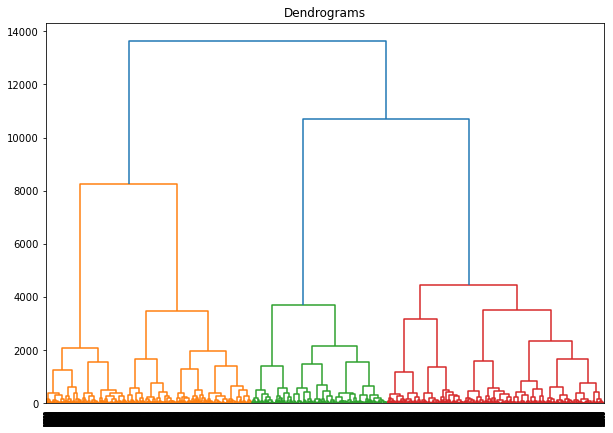

In [584]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(principalDfHC, method='ward'))
plt.axhline(y=130000, color='r', linestyle='--')


Dendrogram graphs shows  that the optimal number of clusters is 4

In [97]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(principalDfHC)

array([2, 0, 0, ..., 2, 0, 1], dtype=int64)

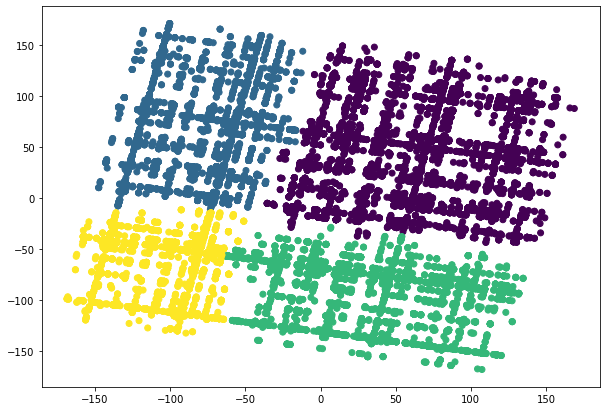

In [98]:
plt.figure(figsize=(10, 7))  
plt.scatter(principalDfHC['principal component 1'], principalDfHC['principal component 2'], c=cluster.labels_) 

## Nivell 3
### Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.


In [93]:
kmeans_sil = silhouette_score(df_scaled.iloc[:,:-1],kmeans.labels_).round(2)

In [94]:
kmeans_sil

0.41

In [99]:
hierarchical_clustering_sil = silhouette_score(principalDfHC,cluster.labels_).round(2)

In [100]:
hierarchical_clustering_sil

0.42

the results of silhouette score shows that the best method approach is hierarchical clustering although no significant diference